### 1. EDA (Exploratory Data Analysis) 

In [10]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

#  데이터프레임 생성 (고객 ID + 연체 여부)
# 고객 ID("customer") , 판매액("sales"), 소득액("income"), 금리( "interest"), 대출금("loans"), 연체여부("status")
df = pd.DataFrame({
    "customer":  [f"고객{i}" for i in range(1, 13)],
    "sales":     [100, 120, 130, 140, 150, 200, 220, 180, 190, 200, 210, 120],
    "income":    [10, 12, 13, 14, 15, 16, 17, 20, 22, 19, 20, 22],
    "interest":  [1.2, 1.5, 1.4, 1.3, 1.4, 1.5, 1.4, 1.4, 1.4, 1.5, 1.5, 1.5],
    "loans": [100, 105, 102, 103, 104, 104, 105, 105, 103, 102, 104, 105],
    "status": [
        "정상", "정상", "연체", "정상", "정상", "정상",
        "정상", "정상", "정상", "정상", "연체", "연체"
    ]
})

df


,customer,sales,income,interest,loans,status
0,고객1,100,10,1.2,100,정상
1,고객2,120,12,1.5,105,정상
2,고객3,130,13,1.4,102,연체
3,고객4,140,14,1.3,103,정상
4,고객5,150,15,1.4,104,정상
5,고객6,200,16,1.5,104,정상
6,고객7,220,17,1.4,105,정상
7,고객8,180,20,1.4,105,정상
8,고객9,190,22,1.4,103,정상
9,고객10,200,19,1.5,102,정상


#### 데이터 규모 & 구조 확인 

In [11]:
# (1) 데이터 크기

df.shape

(12, 6)

In [12]:
# (2) 컬럼 정보 & 결측치
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   customer  12 non-null     object 
 1   sales     12 non-null     int64  
 2   income    12 non-null     int64  
 3   interest  12 non-null     float64
 4   loans     12 non-null     int64  
 5   status    12 non-null     object 
dtypes: float64(1), int64(3), object(2)
memory usage: 704.0+ bytes


In [13]:
# 기초 통계량 (숫자형 변수) 

df.describe()

,sales,income,interest,loans
count,12.000000,12.000000,12.000000,12.000000
mean,163.333333,16.666667,1.416667,103.500000
std,41.194292,3.984820,0.093744,1.566699
min,100.000000,10.000000,1.200000,100.000000
25%,127.500000,13.750000,1.400000,102.750000
50%,165.000000,16.500000,1.400000,104.000000
75%,200.000000,20.000000,1.500000,105.000000
max,220.000000,22.000000,1.500000,105.000000


In [14]:
# sales: 평균, 최소/최대 → 매출 분포 파악
# income: 증가 추세 있는지 확인
# interest: 변동폭이 매우 작음 (모델 기여 낮을 수 있음)
# loans: 범위가 좁아 스케일링 영향 적음

#### 범주형 변수 분석

In [15]:
# (1) 연체 여부 분포

df["status"].value_counts()

df["status"].value_counts(normalize=True) * 100

status
정상    75.0
연체    25.0
Name: proportion, dtype: float64

In [16]:
# 정상: 다수
# 연체: 소수 (불균형 데이터)
# → 분류 문제에서 정확도만 보면 위험

In [17]:
# 그룹별 기초 통계 
# 연체 여부별 평균 비교
df.groupby("status")[["sales", "income", "interest", "loans"]].mean()


,sales,income,interest,loans
status,,,,
연체,153.333333,18.333333,1.466667,103.666667
정상,166.666667,16.111111,1.400000,103.444444


In [18]:
# 해석 예시
# 연체 고객의 평균 매출·소득이 낮은지 확인
# 분류 모델의 설명력 근거

#### 이상치(outlier) 간단 점검

In [19]:
# IQR 기반 요약
# IQR = Q3 − Q1
# → 데이터의 가운데 50%가 퍼져 있는 범위
# Q1 (25% 분위수)
# Q3 (75% 분위수)
# IQR로 이상치를 판단하는 기준
# 하한선 = Q1 − 1.5 × IQR
# 상한선 = Q3 + 1.5 × IQR
# 이 범위를 벗어나면 이상치(outlier) 의심


Q1 = df[["sales", "income", "interest", "loans"]].quantile(0.25)
Q3 = df[["sales", "income", "interest", "loans"]].quantile(0.75)
IQR = Q3 - Q1

outlier_check = (df[["sales", "income", "interest", "loans"]] < (Q1 - 1.5*IQR)) | \
                (df[["sales", "income", "interest", "loans"]] > (Q3 + 1.5*IQR))

outlier_check.sum()


sales       0
income      0
interest    1
loans       0
dtype: int64

In [20]:
# 해석
# 표본이 작으므로 이상치 제거보다는 확인 위주

#### 7:3 (Train : Test) 분할

In [45]:
# 라이브러리 불러오기
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

- 타깃 변수 라벨 인코딩 (머신러닝 필수)

In [46]:
# status(정상/연체)는 문자열이므로 숫자로 변환합니다.
# 원하는 매핑 직접 지정
mapping = {"정상": 0, "연체": 1}

f["y"] = f["status"].map(mapping)

print("라벨 매핑:", mapping)


라벨 매핑: {'정상': 0, '연체': 1}


In [47]:
# 특징(X)과 타깃(y) 분리
X = f[["sales", "income", "interest", "loans"]]
y = f["y"]

In [48]:
# Train / Test 데이터 분할 (7 : 3) 
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,        # Test 30%
    random_state=42,
    stratify=y            # 정상/연체 비율 유지 (중요!)
)



In [49]:
# stratify=y 설명
# 연체/정상 비율이 Train과 Test에 비슷하게 유지되도록 함
# (분류 문제에서 매우 중요)

In [50]:
# 분할 결과 확인
# (1) 데이터 크기 확인

print("X_train 크기:", X_train.shape)
print("X_test 크기 :", X_test.shape)



X_train 크기: (8, 4)
X_test 크기 : (4, 4)


In [51]:
# (2) Train 데이터 확인
X_train

y_train


8     0
1     0
10    1
3     0
0     0
9     0
2     1
6     0
Name: y, dtype: int64

In [52]:
# (3) Test 데이터 확인
X_test

y_test


11    1
7     0
4     0
5     0
Name: y, dtype: int64

In [53]:
# 클래스 비율 확인

print("전체 데이터 비율")
print(y.value_counts())

print("\nTrain 데이터 비율")
print(y_train.value_counts())

print("\nTest 데이터 비율")
print(y_test.value_counts())


전체 데이터 비율
y
0    9
1    3
Name: count, dtype: int64

Train 데이터 비율
y
0    6
1    2
Name: count, dtype: int64

Test 데이터 비율
y
0    3
1    1
Name: count, dtype: int64


### 2. 스케일링

#### 데이터 준비

In [58]:

import pandas as pd

f = pd.DataFrame({
    "customer":  [f"고객{i}" for i in range(1, 13)],
    "sales":     [100, 120, 130, 140, 150, 200, 220, 180, 190, 200, 210, 120],
    "income":    [10, 12, 13, 14, 15, 16, 17, 20, 22, 19, 20, 22],
    "interest":  [1.2, 1.5, 1.4, 1.3, 1.4, 1.5, 1.4, 1.4, 1.4, 1.5, 1.5, 1.5],
    "loans":     [100, 105, 102, 103, 104, 104, 105, 105, 103, 102, 104, 105],
    "status": [
        "정상", "정상", "연체", "정상", "정상", "정상",
        "정상", "정상", "정상", "정상", "연체", "연체"
    ]
})

- 단위와 크기가 다른 변수들을 같은 기준에서 비교·학습시키기 위해서 스케일링 필요

- 원본 데이터
- 변수	값 범위
- 매출(sales)	100 ~ 220
- 소득(income)	10 ~ 22
- 금리(interest)	1.2 ~ 1.5
- 대출금(loans)	100 ~ 105

#### 스케일링 대상 컬럼 선택 (숫자형만)

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# (한글 깨짐 방지 – Windows 기준)
from matplotlib import rc
rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

In [60]:
f = pd.DataFrame({
    "customer":  [f"고객{i}" for i in range(1, 13)],
    "sales":     [100, 120, 130, 140, 150, 200, 220, 180, 190, 200, 210, 120],
    "income":    [10, 12, 13, 14, 15, 16, 17, 20, 22, 19, 20, 22],
    "interest":  [1.2, 1.5, 1.4, 1.3, 1.4, 1.5, 1.4, 1.4, 1.4, 1.5, 1.5, 1.5],
    "loans":     [100, 105, 102, 103, 104, 104, 105, 105, 103, 102, 104, 105],
    "status": [
        "정상", "정상", "연체", "정상", "정상", "정상",
        "정상", "정상", "정상", "정상", "연체", "연체"
    ]
})

In [61]:
# 타깃 라벨 인코딩 (정상=0, 연체=1)

f["y"] = f["status"].map({"정상": 0, "연체": 1})


In [62]:
# Train / Test 7:3 분할

X = f[["sales", "income", "interest", "loans"]]
y = f["y"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape)
print("Test :", X_test.shape)


Train: (8, 4)
Test : (4, 4)


- 원본 데이터
- → 변수 단위·범위가 달라 직접 비교 불가

- 표준화(StandardScaler)
- → 평균 0, 분산 1 → 회귀·거리 기반 모델에 적합

- Min-Max 스케일링
- → 0~1 범위 → 신경망·트리 모델 입력에 적합

- Train 기준 스케일링은 필수 원칙

#### Train 데이터에만 스케일링 적용 (핵심)

##### 표준화 (StandardScaler)

In [63]:
std_scaler = StandardScaler()
X_train_std = pd.DataFrame(
    std_scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)


#### Min-Max 스케일링

In [64]:
mm_scaler = MinMaxScaler()
X_train_mm = pd.DataFrame(
    mm_scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)


In [65]:
# “Scaler는 반드시 Train 데이터로만 fit하고
# Test 데이터에는 transform만 해야 한다.”

#### 스케일링 결과 시각화 비교

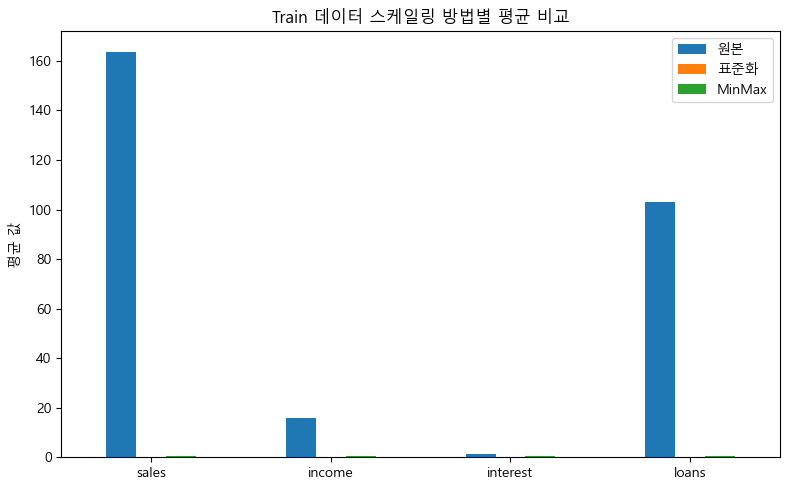

In [67]:
# 변수별 평균 비교 (막대그래프)
compare_mean = pd.DataFrame({
    "원본": X_train.mean(),
    "표준화": X_train_std.mean(),
    "MinMax": X_train_mm.mean()
})

compare_mean.plot(kind="bar", figsize=(8, 5))
plt.title("Train 데이터 스케일링 방법별 평균 비교")
plt.ylabel("평균 값")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


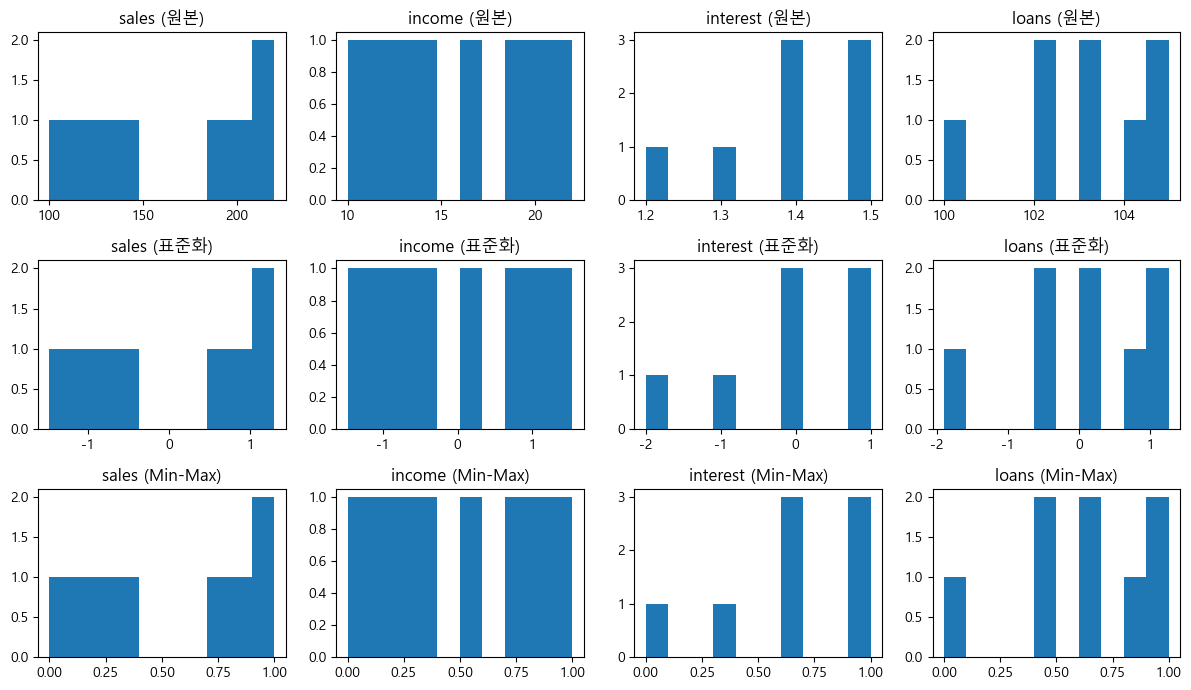

In [68]:
# (2) 분포 비교 (히스토그램)
fig, axes = plt.subplots(3, 4, figsize=(12, 7))

for i, col in enumerate(X_train.columns):
    # 원본
    axes[0, i].hist(X_train[col])
    axes[0, i].set_title(f"{col} (원본)")

    # 표준화
    axes[1, i].hist(X_train_std[col])
    axes[1, i].set_title(f"{col} (표준화)")

    # Min-Max
    axes[2, i].hist(X_train_mm[col])
    axes[2, i].set_title(f"{col} (Min-Max)")

plt.tight_layout()
plt.show()



- 핵심 정리
- 원본 데이터 : → 변수 단위·범위가 달라 직접 비교 불가
- 표준화(StandardScaler) : → 평균 0, 분산 1 → 회귀·거리 기반 모델에 적합
- Min-Max 스케일링 :→ 0~1 범위 → 신경망·트리 모델 입력에 적합
- Train 기준 스케일링은 필수 원칙
- 한 줄 요약
-스케일링은 Train 데이터 기준으로만 수행해야 데이터 누수(Data Leakage)를 막을 수 있다.